In [3]:
# install jika belum ada modelnya
!pip install timm



[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
from timm import create_model
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [7]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📟 Device: {device}")


📟 Device: cuda


In [8]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=5, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])


In [9]:
train_dir = "dataset_vit_aug/train"
test_dir = "dataset_vit/test"

train_dataset = ImageFolder(train_dir, transform=train_transform)
test_dataset = ImageFolder(test_dir, transform=test_transform)

print(f"📊 Train: {len(train_dataset)} | Test: {len(test_dataset)}")
print(f"📂 Classes: {train_dataset.classes}")


📊 Train: 150992 | Test: 33335
📂 Classes: ['A', 'AFIB', 'AFL', 'L', 'N', 'R', 'V']


In [10]:
from torch.utils.data import random_split

train_size = int(0.85 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

print(f"🟢 Train: {len(train_set)} | 🟡 Val: {len(val_set)}")


🟢 Train: 128343 | 🟡 Val: 22649


In [11]:
batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)


In [12]:
model = create_model("pvt_v2_b0", pretrained=True, num_classes=0)  # Hilangkan head dulu
model.head = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model.num_features, len(train_dataset.classes))
)
model = model.to(device)
print("✅ PvT model dengan tuning siap di GPU")


✅ PvT model dengan tuning siap di GPU


In [13]:
import time
from tqdm import tqdm

num_epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler()


C:\Users\pravi\AppData\Local\Temp\ipykernel_8984\3497366540.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [14]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0
    start_time = time.time()

    loop = tqdm(train_loader, desc=f"🚀 Epoch [{epoch+1}/{num_epochs}]")

    for images, labels in loop:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

        loop.set_postfix(loss=loss.item())

    acc = correct / total_samples * 100
    avg_loss = total_loss / len(train_loader)
    mins, secs = divmod(time.time() - start_time, 60)
    print(f"✅ Epoch {epoch+1} selesai - Loss: {avg_loss:.4f} - 🎯 Akurasi: {acc:.2f}% - ⏱️ Durasi: {int(mins)}m {int(secs)}s")
    print(f"📈 GPU Mem Used: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")


🚀 Epoch [1/5]:   0%|          | 0/4011 [00:00<?, ?it/s]C:\Users\pravi\AppData\Local\Temp\ipykernel_8984\3702559720.py:16: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
🚀 Epoch [1/5]: 100%|██████████| 4011/4011 [05:25<00:00, 12.33it/s, loss=0.0839] 


✅ Epoch 1 selesai - Loss: 0.1262 - 🎯 Akurasi: 96.09% - ⏱️ Durasi: 5m 25s
📈 GPU Mem Used: 83.12 MB


🚀 Epoch [2/5]: 100%|██████████| 4011/4011 [05:18<00:00, 12.61it/s, loss=0.158]   


✅ Epoch 2 selesai - Loss: 0.0574 - 🎯 Akurasi: 98.20% - ⏱️ Durasi: 5m 18s
📈 GPU Mem Used: 83.12 MB


🚀 Epoch [3/5]: 100%|██████████| 4011/4011 [05:15<00:00, 12.71it/s, loss=0.009]   


✅ Epoch 3 selesai - Loss: 0.0427 - 🎯 Akurasi: 98.61% - ⏱️ Durasi: 5m 15s
📈 GPU Mem Used: 83.12 MB


🚀 Epoch [4/5]: 100%|██████████| 4011/4011 [05:21<00:00, 12.47it/s, loss=0.00347] 


✅ Epoch 4 selesai - Loss: 0.0345 - 🎯 Akurasi: 98.85% - ⏱️ Durasi: 5m 21s
📈 GPU Mem Used: 83.12 MB


🚀 Epoch [5/5]: 100%|██████████| 4011/4011 [05:28<00:00, 12.21it/s, loss=0.00349] 

✅ Epoch 5 selesai - Loss: 0.0290 - 🎯 Akurasi: 99.06% - ⏱️ Durasi: 5m 28s
📈 GPU Mem Used: 83.12 MB


In [15]:
class_names = train_dataset.classes
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
cm = confusion_matrix(y_true, y_pred)


In [16]:
def calculate_specificity(cm):
    specificity = []
    for i in range(len(cm)):
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(np.delete(cm[:, i], i))
        specificity.append(tn / (tn + fp + 1e-8))
    return specificity

def calculate_per_class_accuracy(cm):
    accuracy = []
    for i in range(len(cm)):
        tp = cm[i, i]
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        acc = (tp + tn) / (tp + tn + fp + fn + 1e-8)
        accuracy.append(acc)
    return accuracy

specificities = calculate_specificity(cm)
accuracies = calculate_per_class_accuracy(cm)


In [17]:
print(f"{'Class':<10} {'Accuracy':>10} {'Precision':>10} {'Sensitivity':>12} {'Specificity':>12} {'F1-Score':>10}")
for idx, cls in enumerate(class_names):
    acc = accuracies[idx] * 100
    prec = report[cls]['precision'] * 100
    sens = report[cls]['recall'] * 100
    spec = specificities[idx] * 100
    f1 = report[cls]['f1-score'] * 100
    print(f"{cls:<10} {acc:10.2f} {prec:10.2f} {sens:12.2f} {spec:12.2f} {f1:10.2f}")


Class        Accuracy  Precision  Sensitivity  Specificity   F1-Score
A               99.63      95.84        87.43        99.91      91.44
AFIB            99.98      99.79        99.97        99.98      99.88
AFL             99.98      97.78        86.27       100.00      91.67
L               99.95      99.67        99.67        99.97      99.67
N               99.44      99.47        99.70        98.89      99.58
R               99.97      99.77        99.82        99.98      99.79
V               99.77      97.91        98.55        99.86      98.23


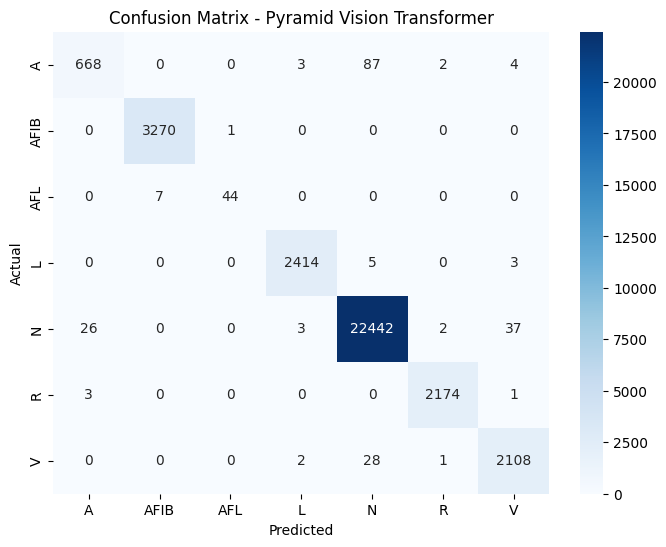

In [18]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Pyramid Vision Transformer")
plt.show()


In [19]:
torch.save(model.state_dict(), "model_pvt_tuning.pth")
print("📦 Model PvT berhasil disimpan!")


📦 Model PvT berhasil disimpan!


📟 Device: cuda
🧪 Test set dipersulit: 33335 sampel
📂 Kelas: ['A', 'AFIB', 'AFL', 'L', 'N', 'R', 'V']
✅ Model PvT dengan tuning berhasil dimuat ulang.


🔍 Evaluating PvT on Augmented Test Set: 100%|██████████| 1042/1042 [00:59<00:00, 17.58it/s]



📈 Classification Report:
              precision    recall  f1-score   support

           A       0.96      0.84      0.90       764
        AFIB       1.00      1.00      1.00      3271
         AFL       0.98      0.82      0.89        51
           L       1.00      0.99      0.99      2422
           N       0.99      1.00      0.99     22510
           R       0.99      1.00      0.99      2178
           V       0.97      0.98      0.98      2139

    accuracy                           0.99     33335
   macro avg       0.98      0.95      0.96     33335
weighted avg       0.99      0.99      0.99     33335



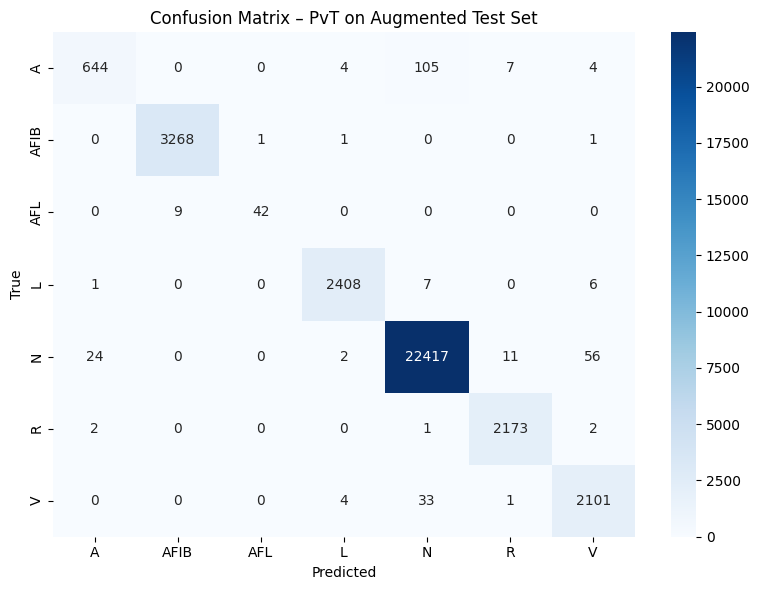


Class        Accuracy  Precision  Sensitivity  Specificity   F1-Score
A               99.56      95.98        84.29        99.92      89.76
AFIB            99.96      99.73        99.91        99.97      99.82
AFL             99.97      97.67        82.35       100.00      89.36
L               99.93      99.55        99.42        99.96      99.48
N               99.28      99.35        99.59        98.65      99.47
R               99.93      99.13        99.77        99.94      99.45
V               99.68      96.82        98.22        99.78      97.52


In [20]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from timm import create_model

# === Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📟 Device: {device}")

# === Test Augmentasi Berat
test_dir = "dataset_vit/test"
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.4, contrast=0.4),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
classes = test_dataset.classes
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
print(f"🧪 Test set dipersulit: {len(test_dataset)} sampel")
print(f"📂 Kelas: {classes}")

# === Load Model PvT dengan Tuning
model = create_model("pvt_v2_b0", pretrained=True, num_classes=0)
model.head = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model.num_features, len(classes))
)
model.load_state_dict(torch.load("model_pvt_tuning.pth"))  # Ganti path kalau berbeda
model = model.to(device)
model.eval()
print("✅ Model PvT dengan tuning berhasil dimuat ulang.")

# === Evaluasi Model
y_true, y_pred = [], []
with torch.no_grad():
    loop = tqdm(test_loader, desc="🔍 Evaluating PvT on Augmented Test Set")
    for images, labels in loop:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# === Classification Report & Confusion Matrix
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
print("\n📈 Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – PvT on Augmented Test Set")
plt.tight_layout()
plt.show()

# === Metrik Tambahan: Specificity & Accuracy per Class
def calculate_specificity(cm):
    specificity = []
    for i in range(len(cm)):
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(np.delete(cm[:, i], i))
        specificity.append(tn / (tn + fp + 1e-8))
    return specificity

def calculate_per_class_accuracy(cm):
    accuracy = []
    for i in range(len(cm)):
        tp = cm[i, i]
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        acc = (tp + tn) / (tp + tn + fp + fn + 1e-8)
        accuracy.append(acc)
    return accuracy

specificities = calculate_specificity(cm)
accuracies = calculate_per_class_accuracy(cm)

# === Print Tabel Evaluasi per Kelas
print(f"\n{'Class':<10} {'Accuracy':>10} {'Precision':>10} {'Sensitivity':>12} {'Specificity':>12} {'F1-Score':>10}")
for idx, cls in enumerate(classes):
    acc = accuracies[idx] * 100
    prec = report[cls]['precision'] * 100
    sens = report[cls]['recall'] * 100
    spec = specificities[idx] * 100
    f1 = report[cls]['f1-score'] * 100
    print(f"{cls:<10} {acc:10.2f} {prec:10.2f} {sens:12.2f} {spec:12.2f} {f1:10.2f}")


📟 Device: cuda
🧪 Evaluasi di Data Train (augmented): 150992 sampel
📂 Kelas: ['A', 'AFIB', 'AFL', 'L', 'N', 'R', 'V']
✅ Model PvT dengan tuning berhasil dimuat ulang.


🔍 Evaluating on Train Set (PvT): 100%|██████████| 4719/4719 [03:54<00:00, 20.09it/s]



📈 Classification Report:
              precision    recall  f1-score   support

           A       0.99      0.91      0.95      7128
        AFIB       1.00      1.00      1.00     30520
         AFL       0.99      0.89      0.94       464
           L       1.00      1.00      1.00     22604
           N       0.98      1.00      0.99     50000
           R       1.00      1.00      1.00     20316
           V       1.00      0.99      0.99     19960

    accuracy                           0.99    150992
   macro avg       0.99      0.97      0.98    150992
weighted avg       0.99      0.99      0.99    150992



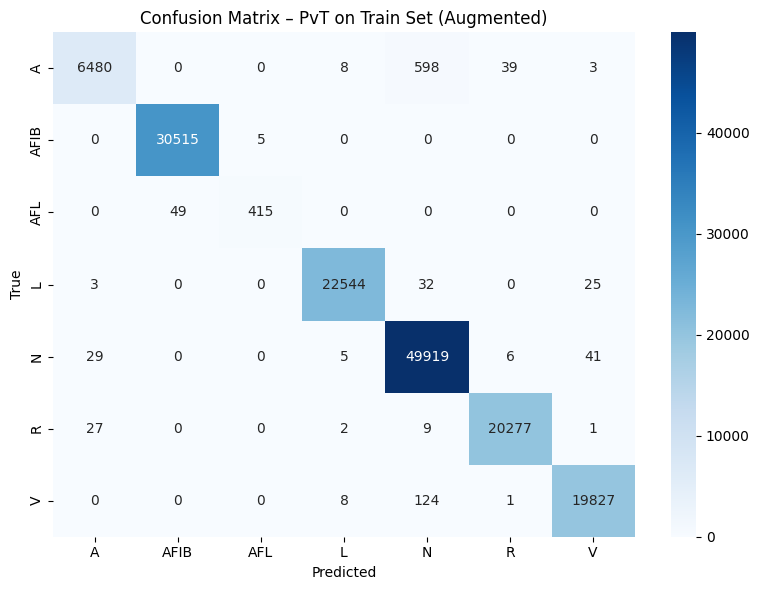


Class        Accuracy  Precision  Sensitivity  Specificity   F1-Score
A               99.53      99.10        90.91        99.96      94.83
AFIB            99.96      99.84        99.98        99.96      99.91
AFL             99.96      98.81        89.44       100.00      93.89
L               99.95      99.90        99.73        99.98      99.82
N               99.44      98.49        99.84        99.24      99.16
R               99.94      99.77        99.81        99.96      99.79
V               99.87      99.65        99.33        99.95      99.49


In [21]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from timm import create_model

# === Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📟 Device: {device}")

# === Path Train Dataset
train_dir = "dataset_vit_aug/train"

# === Transformasi ringan (tanpa augmentasi berat)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# === Load Dataset
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
classes = train_dataset.classes
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
print(f"🧪 Evaluasi di Data Train (augmented): {len(train_dataset)} sampel")
print(f"📂 Kelas: {classes}")

# === Load Model PvT hasil tuning
model = create_model("pvt_v2_b0", pretrained=True, num_classes=0)
model.head = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model.num_features, len(classes))
)
model.load_state_dict(torch.load("model_pvt_tuning.pth"))  # ganti jika berbeda
model = model.to(device)
model.eval()
print("✅ Model PvT dengan tuning berhasil dimuat ulang.")

# === Evaluasi Model pada Data Train
y_true, y_pred = [], []
with torch.no_grad():
    loop = tqdm(train_loader, desc="🔍 Evaluating on Train Set (PvT)")
    for images, labels in loop:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# === Classification Report
print("\n📈 Classification Report:")
report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
print(classification_report(y_true, y_pred, target_names=classes))

# === Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – PvT on Train Set (Augmented)")
plt.tight_layout()
plt.show()

# === Perhitungan Metrik Tambahan
def calculate_specificity(cm):
    specificity = []
    for i in range(len(cm)):
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(np.delete(cm[:, i], i))
        specificity.append(tn / (tn + fp + 1e-8))
    return specificity

def calculate_per_class_accuracy(cm):
    accuracy = []
    for i in range(len(cm)):
        tp = cm[i, i]
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(cm[:, i]) - tp
        fn = np.sum(cm[i, :]) - tp
        acc = (tp + tn) / (tp + tn + fp + fn + 1e-8)
        accuracy.append(acc)
    return accuracy

specificities = calculate_specificity(cm)
accuracies = calculate_per_class_accuracy(cm)

# === Tabel Evaluasi Per Kelas
print(f"\n{'Class':<10} {'Accuracy':>10} {'Precision':>10} {'Sensitivity':>12} {'Specificity':>12} {'F1-Score':>10}")
for idx, cls in enumerate(classes):
    acc = accuracies[idx] * 100
    prec = report[cls]['precision'] * 100
    sens = report[cls]['recall'] * 100
    spec = specificities[idx] * 100
    f1 = report[cls]['f1-score'] * 100
    print(f"{cls:<10} {acc:10.2f} {prec:10.2f} {sens:12.2f} {spec:12.2f} {f1:10.2f}")
